# A prenatal combined test used to screen for chromosomal abnormalities in pregnancies.
1. create a synthetic data to simulate the training set
2. fit a classification model
3. analyze and compare the metrics to understand why the F1-score is so low (0.15) despite seemingly good test characteristics (sensitivity: 90%, specificity: 95% )

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D

## 1. Creating a Synthetic Training set resembling the described context
- A population of 10,000 individuals
- 50 individuals with the condition (0.5%)
- Test sensitivity: 90% (correctly identifies 90% of true positives)
- Test specificity: 95% (has a 5% false positive rate)
## three features selected:
1. *Maternal age* - Older maternal age is strongly correlated with increased risk of chromosomal abnormalities like Down syndrome
2. *Nuchal translucency* - This ultrasound measurement of fluid at the back of the fetal neck is a key biomarker in prenatal screening
3. *family history*: 1 = positive family history, 0 = no family history.
    - Higher probability of positive family history in affected cases
    - Lower probability of positive family history in unaffected cases

In [2]:
np.random.seed(42)  # For reproducibility

# Total population
total_population = 10000

# Number of individuals with the condition (0.5% prevalence)
num_positive = 50

# Number of individuals without the condition
num_negative = total_population - num_positive

# Create dataset with two features: maternal age and nuchal translucency

df = pd.DataFrame()
#features for positive cases
pos_feature1 = np.random.normal(loc=35, scale=5, size=num_positive)  # Higher maternal age
pos_feature2 = np.random.normal(loc=3.5, scale=0.8, size=num_positive)  # Higher nuchal translucency

#features for negative cases
neg_feature1 = np.random.normal(loc=28, scale=5, size=num_negative)  # Lower maternal age
neg_feature2 = np.random.normal(loc=1.8, scale=0.7, size=num_negative)  # Lower nuchal translucency

# feature for family history
pos_family_history = np.random.choice([0, 1], size=num_positive, p=[0.5, 0.5]) # Higher probability of positive family history in affected cases
neg_family_history = np.random.choice([0, 1], size=num_negative, p=[0.9, 0.1]) # Lower probability of positive family history in unaffected cases

# Combine the data
df['feature1'] = np.concatenate([pos_feature1, neg_feature1])
df['feature2'] = np.concatenate([pos_feature2, neg_feature2])
df['feature3'] = np.concatenate([pos_family_history, neg_family_history])

# Add true condition status (1 = has condition, 0 = doesn't have condition)
df['true_condition'] = np.concatenate([np.ones(num_positive), np.zeros(num_negative)])

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.describe()

,feature1,feature2,feature3,true_condition
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,28.027050,1.817601,0.096600,0.005000
std,5.033893,0.711339,0.295427,0.070537
min,8.387999,-0.899463,0.000000,0.000000
25%,24.659482,1.338239,0.000000,0.000000
50%,28.016308,1.812722,0.000000,0.000000
75%,31.406801,2.291866,0.000000,0.000000
max,47.631189,4.935359,1.000000,1.000000


In [3]:
df.head()

,feature1,feature2,feature3,true_condition
0,32.040289,1.544407,0,0.0
1,29.456014,1.797566,0,0.0
2,34.134666,1.496177,0,0.0
3,19.215657,1.368201,0,0.0
4,31.113556,2.348313,0,0.0


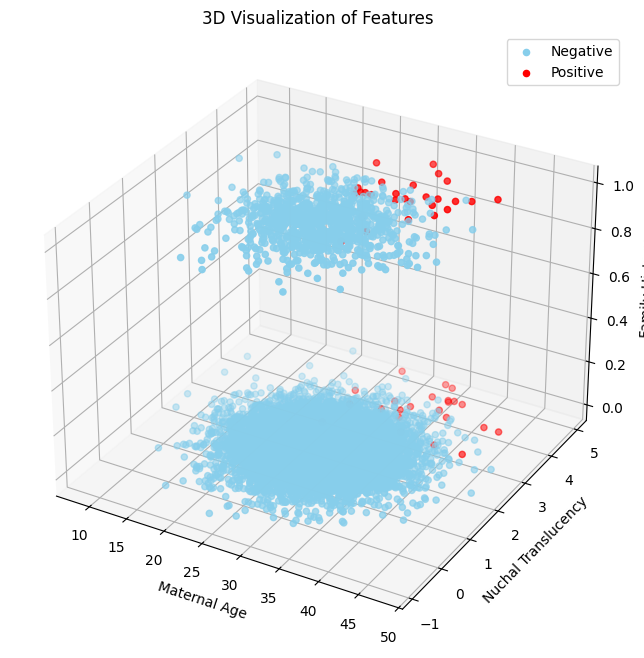

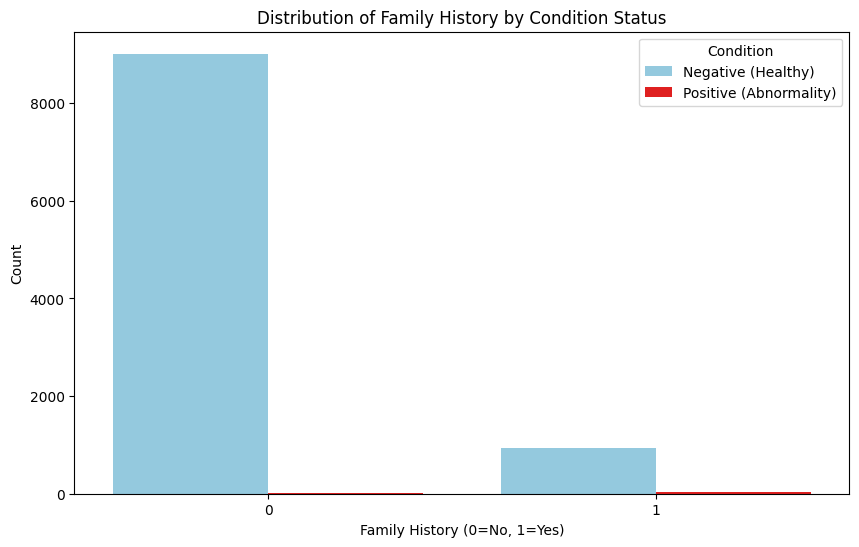

In [4]:
#visualizing three features 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with different colors based on condition
ax.scatter(df[df['true_condition']==0]['feature1'], 
           df[df['true_condition']==0]['feature2'],
           df[df['true_condition']==0]['feature3'],
           c='skyblue', label='Negative')
ax.scatter(df[df['true_condition']==1]['feature1'], 
           df[df['true_condition']==1]['feature2'],
           df[df['true_condition']==1]['feature3'],
           c='red', label='Positive')

ax.set_xlabel('Maternal Age')
ax.set_ylabel('Nuchal Translucency')
ax.set_zlabel('Family History')
ax.legend()
plt.title('3D Visualization of Features')
plt.show()

# Since family history is binary, plot a different graph
plt.figure(figsize=(10, 6))
sns.countplot(x='feature3', hue='true_condition', data=df, palette={0: 'skyblue', 1: 'red'})
plt.xlabel('Family History (0=No, 1=Yes)')
plt.ylabel('Count')
plt.title('Distribution of Family History by Condition Status')
plt.legend(title='Condition', labels=['Negative (Healthy)', 'Positive (Abnormality)'])
plt.show()

## 2. Create a fit classification model with approximately 90% sensitivity and 95% specificity:
binary classification --> logistic regression

in questo caso non penso sia importante la scelta modello quanto piuttosto capire il perchè dell'output F1score e come è correlato a sensitività/specificità

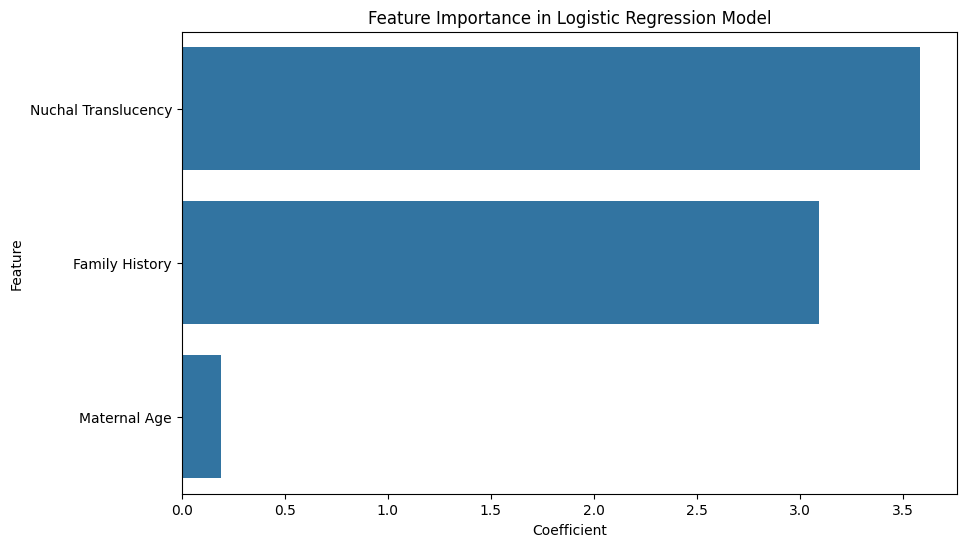

Optimal threshold: 0.5596
Resulting specificity: 0.9500
Resulting sensitivity: 0.9412


In [5]:
# Split data into training and testing sets
X = df[['feature1', 'feature2','feature3']]
y = df['true_condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model
model = LogisticRegression(class_weight='balanced')
#The class_weight='balanced' parameter automatically adjusts weights inversely
#proportional to class frequencies, helping the model better detect the minority class.
model.fit(X_train, y_train)

# Adjust decision threshold to get desired sensitivity/specificity
# First, get the probabilities
y_train_proba = model.predict_proba(X_train)[:, 1]

# Examine coefficients
if hasattr(model, 'coef_'):
    feature_names = ['Maternal Age', 'Nuchal Translucency', 'Family History']
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]
    })
    importance = importance.sort_values('Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=importance)
    plt.title('Feature Importance in Logistic Regression Model')
    plt.show()

# Find threshold that gives approximately 95% specificity
thresholds = np.linspace(0, 1, 1000)
specificities = []
sensitivities = []

for threshold in thresholds:
    y_pred = (y_train_proba >= threshold).astype(int)
    
    # Calculate specificity (true negative rate)
    tn = np.sum((y_train == 0) & (y_pred == 0))
    fp = np.sum((y_train == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate sensitivity (true positive rate)
    tp = np.sum((y_train == 1) & (y_pred == 1))
    fn = np.sum((y_train == 1) & (y_pred == 0))
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    specificities.append(specificity)
    sensitivities.append(sensitivity)

specificities = np.array(specificities)
sensitivities = np.array(sensitivities)

# Find threshold closest to 95% specificity
target_specificity = 0.95
threshold_idx = np.argmin(np.abs(specificities - target_specificity))
optimal_threshold = thresholds[threshold_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Resulting specificity: {specificities[threshold_idx]:.4f}")
print(f"Resulting sensitivity: {sensitivities[threshold_idx]:.4f}")

optimizing for F1-score will likely decrease specificity, resulting in more false positives. This represents a fundamental trade

In [6]:
# Evaluating the Model. apply the model to the test set and evaluate its performance using the threshold

# Get probabilities for the test set
y_test_proba = model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_pred = (y_test_proba >= optimal_threshold).astype(int)

# Create a DataFrame with true values and predictions
results_df = pd.DataFrame({
    'True Condition': y_test,
    'Predicted': y_pred,
    'Probability': y_test_proba
})

results_df.head()

,True Condition,Predicted,Probability
6252,0.0,0,0.000056
4684,0.0,0,0.005221
1731,0.0,0,0.289183
4742,0.0,0,0.006427
4521,0.0,0,0.006152


In [7]:
## 7. Understanding the Low Precision Issue
#Now let's specifically examine why the precision is so low despite good sensitivity and specificity.

# Calculate expected false positives and true positives in a population of 10,000
expected_true_positive = 10000 * 0.005 * 0.9  # population × prevalence × sensitivity
expected_false_positive = 10000 * 0.995 * 0.05  # population × (1-prevalence) × (1-specificity)

print(f"Expected number of true positives: {expected_true_positive:.1f}\n")
print(f"Expected number of false positives: {expected_false_positive:.1f}\n")
print(f"Total positive test results: {expected_true_positive + expected_false_positive:.1f}\n")

expected_precision = expected_true_positive / (expected_true_positive + expected_false_positive)
print(f"Expected precision: {expected_precision*100:.1f}%\n")

# This means that about 92% of positive test results are false positives!
print(f"False discovery rate: {(1-expected_precision)*100:.1f}%")

Expected number of true positives: 45.0

Expected number of false positives: 497.5

Total positive test results: 542.5

Expected precision: 8.3%

False discovery rate: 91.7%


## 3. compare results with the test results described in the link

### F1 Score <a id="f1-score"></a>

The F1 score is the harmonic mean of precision and recall, providing a balance between them. It's especially useful for imbalanced datasets.

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

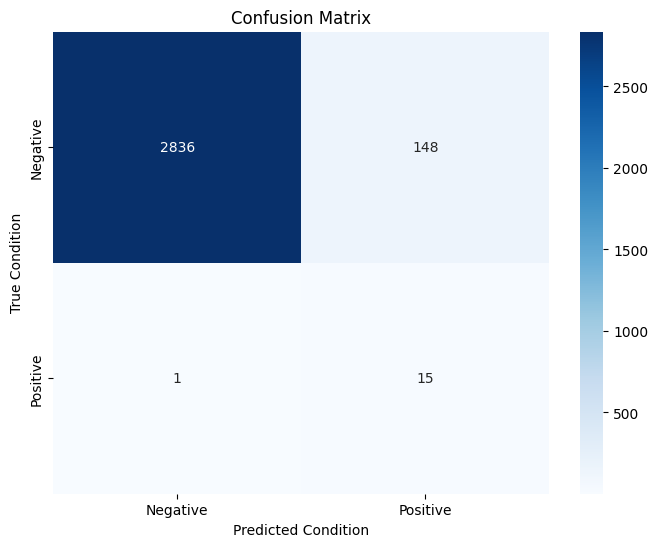

Precision: 0.0920
Recall (Sensitivity): 0.9375
F1-Score: 0.1676

Manual calculations:
Prevalence of condition: 0.0053 (expected: 0.005)
Sensitivity: 0.9375 (expected: ~0.90)
Specificity: 0.9504 (expected: ~0.95)
Precision: 0.0920

Expected F1-score from problem description: 0.1469


In [8]:
#Calculating Performance Metrics

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Condition')
plt.xlabel('Predicted Condition')
plt.title('Confusion Matrix')
plt.show()

# Calculate performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Let's also calculate these manually to understand what's happening
tn, fp, fn, tp = conf_matrix.ravel()

total = tn + fp + fn + tp
prevalence = (tp + fn) / total

sensitivity_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_manual = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0

print("\nManual calculations:")
print(f"Prevalence of condition: {prevalence:.4f} (expected: 0.005)")
print(f"Sensitivity: {sensitivity_manual:.4f} (expected: ~0.90)")
print(f"Specificity: {specificity_manual:.4f} (expected: ~0.95)")
print(f"Precision: {precision_manual:.4f}")


# Expected F1-score
expected_f1 = 2 * (0.08 * 0.9) / (0.08 + 0.9) # 2*(precision*recall)/(precision+recall)
print(f"\nExpected F1-score from problem description: {expected_f1:.4f}")

- a test with 90% sensitivity and 95% specificity still has a low precision (about 8%) and therefore a low F1-score (about 0.15) when the prevalence of the condition is only 0.5%.

- More accurate and more expensive testing like NIPT (Non-Invasive Prenatal Testing) may be justified despite the higher cost, as it significantly reduces false positives and the associated anxiety and potential risks of invasive follow-up tests.

- NIPT base è quello che valuta le anomalie sui cromosomi 21, 18 e 13. 
Il NIPT esteso (cioè analisi su tutti i cromosomi) è a pagamento in tutte le regioni. 
In Toscana nel pubblico varia fra i 350€ ai 550€ a seconda del livello di rischio

- passando da 2 a 3 feature miglioro F1-score da 0.11 a 0.167